In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math


# Step 1: Generate the data 
I'm aiming to generate 100000 datapoints from a Gaussian mixture model of k = 15 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [3]:
n = 100000 # Number of datapoints
k = 15 # Number of components

# Randomising the weights
weights = np.random.uniform(low = 0.75, high = 1, size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
variance = np.random.uniform(low=0.75, high=1.5, size=(k, ))


In [4]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

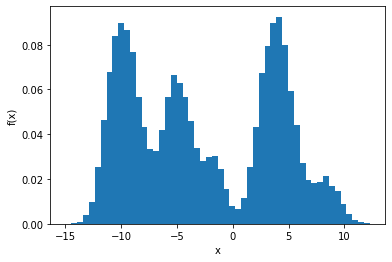

In [5]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [6]:

# First, define a way to calculate pdf 

def pdf(x, input_mean, input_var):
    return math.exp(-0.5 * ((x - input_mean) ** 2 ) / input_var) / (math.sqrt(2 * math.pi * input_var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [7]:
# Using numpy to calculate pdf, and then normalise it across k components
def calculate_p_matrix(x, input_mean, input_var, input_weight):
    # Duplicate data so dimensions work out
    mean_matrix = np.tile(input_mean, (n, 1)).T
    variance_matrix = np.tile(input_var, (n, 1)).T
    weight_matrix = np.tile(input_weight, (n, 1)).T
    
    # PDF calculation
    p_matrix = weight_matrix * np.exp(-0.5 * np.power(x - mean_matrix, 2) / variance_matrix) / (np.sqrt(2 * np.pi * variance_matrix))
    
    p_matrix = p_matrix.transpose(1, 0)
    
    return p_matrix


In [8]:

# Define a metric to evaluate our return from EM alg.
# Hardcoded P_value to save time


# Old implementation

old_P_value = np.zeros((n,))
for i in range(n):
    for j in range(k):
        old_P_value[i] += weights[j] * pdf(data[i], mean[j], variance[j])


# New implementation with numpy, more efficient
P_value = np.sum(calculate_p_matrix(data, mean, variance, weights), axis = 1)
   
print("new", P_value)
print("old", old_P_value)

new [0.07289326 0.03680669 0.00373709 ... 0.07845436 0.00905348 0.07705684]
old [0.07289326 0.03680669 0.00373709 ... 0.07845436 0.00905348 0.07705684]


In [9]:

# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.

    
def KL_div(pred_mean, pred_variance, pred_weights):
    # Old implementation
    """KL_divergence = 0
    for i in range(n):
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_variance[j])
            #P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value[i] * math.log(P_value[i]/Q_value, math.e) - P_value[i] + Q_value"""
    
    
    
    # New implementation
    Q_value = np.sum(calculate_p_matrix(data, pred_mean, pred_variance, pred_weights), axis = 1)
    
    KL_divergence = np.sum(P_value * np.log(P_value / Q_value) - P_value + Q_value)
    
    return KL_divergence
    
assert KL_div(mean, variance, weights) == 0



In [10]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

"""scaling_factor_plot = [[] for j in range(k)]
print(scaling_factor_plot)
"""
# Starts with random means, variances and weights
predicted_mean = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights = np.random.random(size=(k, ))
predicted_weights = predicted_weights / np.sum(predicted_weights) 

def traditional_EM():
    
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    probability_matrix = np.zeros((n, k))
    normalised_p_matrix = np.zeros((n, k))
    
    while prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        # This is the old implementation using python loops. I need to redo this part in numpy to optimise bc it takes too much time.
        """for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum"""
        
        probability_matrix = calculate_p_matrix(data, predicted_mean, predicted_variance, predicted_weights)
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
        """for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            scaling_factor_plot[j].append(np.sum(probability_matrix[:, j]))"""
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
                
        for j in range(k):
            
            predicted_weights[j] = (1/n) * np.sum(probability_matrix[:, j])
            predicted_mean[j] = np.sum(normalised_p_matrix[:, j] * data)
            
            predicted_variance[j] = np.sum(normalised_p_matrix[:, j] * (data - predicted_mean[j]) ** 2)
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
        
        if counter % 5 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return predicted_mean, predicted_variance, predicted_weights, divergence_plot



In [11]:
predicted_mean, predicted_variance, predicted_weights, plot = traditional_EM()

kl div: 10717.143154638532
kl div: 267.6963038922512  |  iter: 0  |  difference vs the prev iter: inf
kl div: 121.93970763638545  |  iter: 5  |  difference vs the prev iter: 26.981585105834455
kl div: 29.703686929233687  |  iter: 10  |  difference vs the prev iter: 14.423486922595814
kl div: 12.823543592678584  |  iter: 15  |  difference vs the prev iter: 1.8004466075726704
kl div: 10.611285550566867  |  iter: 20  |  difference vs the prev iter: 0.2811214024631763
kl div: 9.881068018813275  |  iter: 25  |  difference vs the prev iter: 0.13286751134123165
kl div: 8.930528025806098  |  iter: 30  |  difference vs the prev iter: 0.21229484447732716
kl div: 6.979570888657124  |  iter: 35  |  difference vs the prev iter: 0.4427535564339431
kl div: 4.952663230685455  |  iter: 40  |  difference vs the prev iter: 0.3609194075147313
kl div: 4.173414424182849  |  iter: 45  |  difference vs the prev iter: 0.11557592338458722
kl div: 3.914879025502141  |  iter: 50  |  difference vs the prev iter: 0

In [16]:
print("----- TARGET DISTRIBUTION ------")
for i in range(k):
    print("component mean:", mean[i], "| variance:", variance[i], "| weight:", weights[i])

print("----- LEARNED DISTRIBUTION ------")
for i in range(k):
    print("component mean:", predicted_mean[i], "| variance:", predicted_variance[i], "| weight:", predicted_weights[i])

----- TARGET DISTRIBUTION ------
component mean: 3.753669186817536 | variance: 1.4033099447563646 | weight: 0.07712134160131523
component mean: 8.354014774500548 | variance: 1.4085399998986485 | weight: 0.05884515529781231
component mean: -5.430458731909366 | variance: 0.7609471056871673 | weight: 0.07088369522100216
component mean: -9.405707844197863 | variance: 0.8195044497661425 | weight: 0.07051182748326187
component mean: 3.8303009698309616 | variance: 1.4948393230544235 | weight: 0.06274113437319175
component mean: -5.13589832969503 | variance: 1.4535721118491596 | weight: 0.06418274170737653
component mean: -3.9572820505726405 | variance: 0.8438852291476824 | weight: 0.06987047417552879
component mean: -10.418608773737912 | variance: 1.4796950818866659 | weight: 0.06975642466722631
component mean: -1.5542419190164782 | variance: 0.7745868345096016 | weight: 0.0661071110833318
component mean: 5.180346995409693 | variance: 1.0911518801538571 | weight: 0.06728669524826118
component

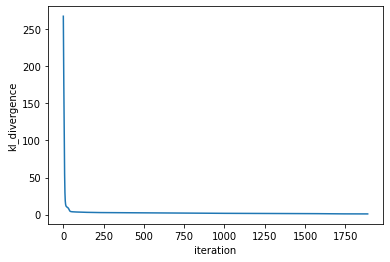

In [17]:
plt.plot([i for i in range(len(plot))], plot)
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


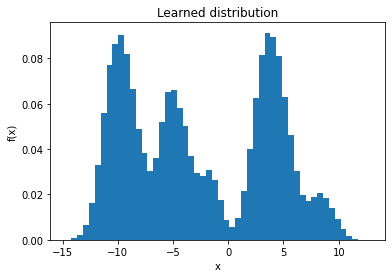

In [20]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean[index], scale = np.sqrt([predicted_variance[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

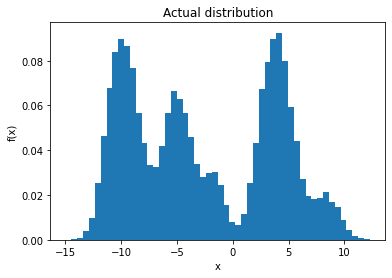

In [21]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()